In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-02-10 09:12:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2024-02-10 09:12:30 (38.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
file_name = 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

df = pd.read_csv(file_name,
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
df = df[['Closing Price (USD)']].rename(columns={'Closing Price (USD)':'Price'})

<Axes: xlabel='Date'>

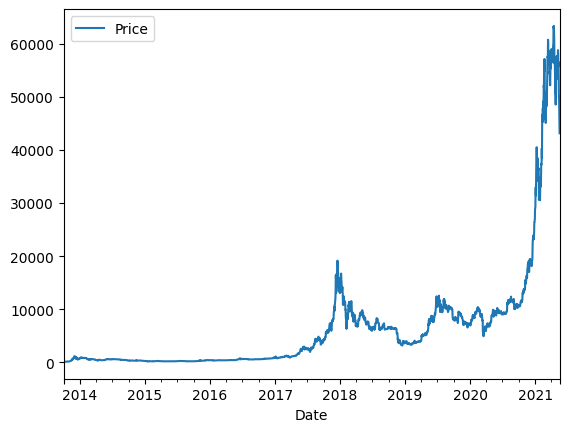

In [6]:
df.plot.line()

In [7]:
import csv
from datetime import datetime

with open(file_name) as f:
  csv_reader = csv.reader(f,delimiter=',')
  columns = next(csv_reader)
  date = []
  price = []
  for line in csv_reader:
    date.append(datetime.strptime(line[1],'%Y-%m-%d'))
    price.append(float(line[2]))

print(columns)

['Currency', 'Date', 'Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']


In [8]:
import numpy as np
X = np.arange(len(df))
y = df['Price']


In [9]:
test_size = int(X.shape[0]*0.2//1)
train_size = int(-test_size + X.shape[0])

In [10]:
train_size

2230

### Naive forecast

In [11]:
X_naive = X[1:]
y_naive = y[:-1]

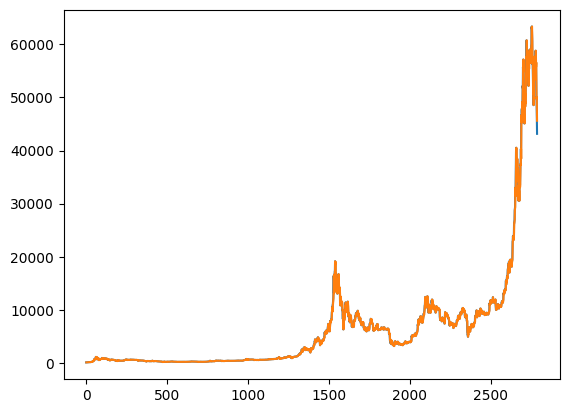

In [12]:
import matplotlib.pyplot as plt
y_naive.shape


plt.plot(X,y)
plt.plot(X_naive,y_naive)

In [13]:
# Customized mean absolute scalled error by help of ChatGPT (measuring fcst err with setting scale of naive fcst to 1)

def mase(y_true,y_pred):
  sum_absolute_err = np.mean(np.abs(y_pred - y_true))
  sum_absolute_diff = np.mean(np.abs(y_true[:-1]-y_true[1:]))
  print(sum_absolute_err,sum_absolute_diff)
  mase = sum_absolute_err / sum_absolute_diff
  return mase

In [14]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season



In [15]:
# Preprocess function to create a windowed data

def window_data(data,HORIZON,WINDOW_SIZE):
  n = len(data) - WINDOW_SIZE - HORIZON + 1
  if n <=0:
    raise ValueError('invalid sizes')
  X = []
  y = []
  for i in range(n):
    X.append(np.array(data[i:i+WINDOW_SIZE]))
    y.append(np.array(data[i+WINDOW_SIZE:i+WINDOW_SIZE+HORIZON]))

  return np.array(X),np.array(y)


HORIZON = 1
WINDOW_SIZE = 7
X_win, y_win = window_data(y.values,1,7)
X_win.shape,y_win.shape

((2780, 7), (2780, 1))

In [16]:
X_win[0],y_win[0]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 array([123.033]))

In [17]:
df[['Price']][:8]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300


<ipython-input-18-f8b1edbb53d3>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_0.fit(X_train,y_train)


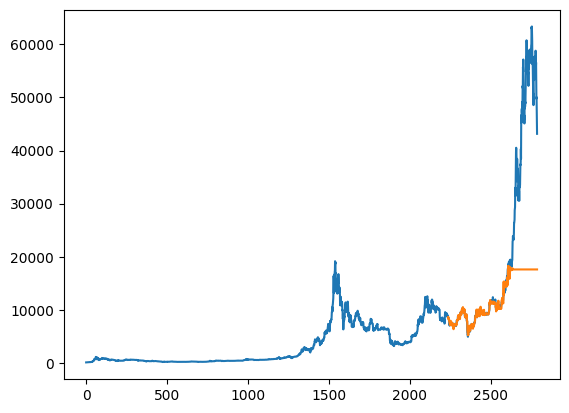

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

X_train = X_win[:train_size]
X_test = X_win[train_size:]
y_train = y_win[:train_size]
y_test = y_win[train_size:]
model_0 = RandomForestRegressor()

model_0.fit(X_train,y_train)
predictions = model_0.predict(X_test)

plt.plot(X,y)
plt.plot(X[train_size+WINDOW_SIZE:],predictions)
plt.show()

## Building Models

### 1 Dense

In [19]:
from tensorflow.keras import layers
def create_check_point(file_name):
  return tf.keras.callbacks.ModelCheckpoint(file_name,save_best_only = True, verbose=0)



model_1 = tf.keras.models.Sequential([
    layers.Dense(64,activation='relu',input_shape=(7,)),
    layers.Dense(1,activation='linear')
])

model_1.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
y_train.shape

(2230, 1)

In [21]:
model_1.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
            callbacks=[create_check_point('model_1')])

Epoch 1/10
70/70 [==============================] - 5s 34ms/step - loss: 1202.6074 - mae: 1202.6074 - val_loss: 1156.5814 - val_mae: 1156.5814
Epoch 2/10
70/70 [==============================] - 1s 19ms/step - loss: 195.2743 - mae: 195.2743 - val_loss: 1039.2855 - val_mae: 1039.2855
Epoch 3/10
70/70 [==============================] - 1s 20ms/step - loss: 174.6080 - mae: 174.6080 - val_loss: 904.8224 - val_mae: 904.8224
Epoch 4/10
70/70 [==============================] - 1s 9ms/step - loss: 151.0400 - mae: 151.0400 - val_loss: 911.5506 - val_mae: 911.5506
Epoch 5/10
70/70 [==============================] - 2s 33ms/step - loss: 143.4229 - mae: 143.4229 - val_loss: 755.3071 - val_mae: 755.3071
Epoch 6/10
70/70 [==============================] - 1s 16ms/step - loss: 129.6051 - mae: 129.6051 - val_loss: 705.3899 - val_mae: 705.3899
Epoch 7/10
70/70 [==============================] - 1s 20ms/step - loss: 125.5470 - mae: 125.5470 - val_loss: 655.3904 - val_mae: 655.3904
Epoch 8/10
70/70 [====

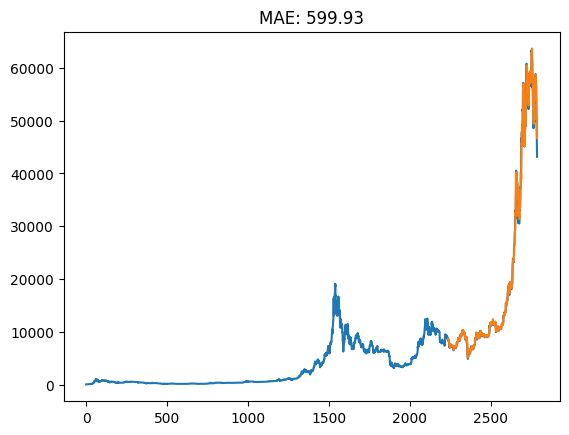

In [22]:
def evaluate_model(y_true,y_pred,x = X[train_size+WINDOW_SIZE:]):
  plt.plot(X,y)
  plt.plot(x,
          y_pred)
  mase = mean_absolute_error(y_true, y_pred)
  plt.title(f'MAE: {mase:.2f}')
  plt.show()


model_1 = tf.keras.models.load_model('model_1')
evaluate_model(y_test,model_1.predict(X_test,verbose=0))

### 3 Dense NN with Window of 30

In [23]:
X_win,y_win = window_data(y,1,30)
X_win.shape,y_win.shape

((2757, 30), (2757, 1))

In [24]:
X_train = X_win[:train_size]
X_test = X_win[train_size:]

y_train = y_win[:train_size]
y_test = y_win[train_size:]

In [25]:
model_3 = tf.keras.models.Sequential([
    layers.Dense(64,activation='relu',input_shape=(30,)),
    layers.Dense(1,activation='linear')
])

model_3.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_3.summary()

model_3.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
            callbacks=[create_check_point('model_3')])
model_3 = tf.keras.models.load_model('model_3')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2049 (8.00 KB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
70/70 [==============================] - 3s 16ms/step - loss: 253.7263 - mae: 253.7263 - val_loss: 1078.4985 - val_mae: 1078.4985
Epoch 2/10
70/70 [==============================] - 1s 9ms/step - loss: 189.8315 - mae: 189.8315 - val_loss: 1014.9839 - val_mae: 1014.9839
Epoch 3/10
70/70 [==============================] - 1s 8ms/step - loss: 175.4422 - mae: 175.4422 - val_loss: 913.7144 - val_mae: 913.7144

In [26]:
X_test.shape,X_train.shape

((527, 30), (2230, 30))

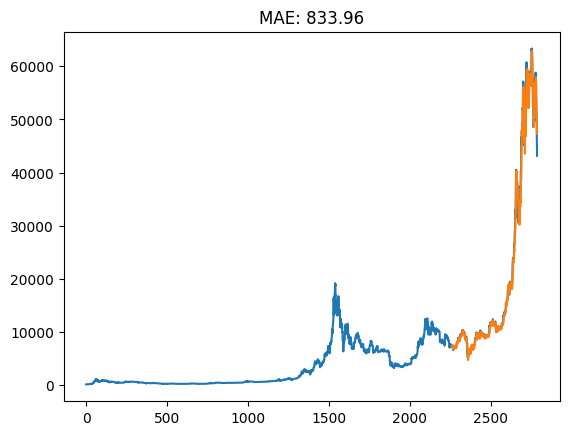

In [27]:
evaluate_model(y_test,model_3.predict(X_test,verbose=0),x = list(range(2230+30,2230+527+30)))

### 4 Dense with horizon of 7 window of 30

In [28]:
X_win,y_win = window_data(y,7,30)
X_train = X_win[:train_size]
X_test = X_win[train_size:]
y_train = y_win[:train_size]
y_test = y_win[train_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2230, 30), (521, 30), (2230, 7), (521, 7))

In [29]:
model_4 = tf.keras.models.Sequential([
    layers.Dense(64,activation='relu',input_shape=(30,)),
    layers.Dense(7,activation='linear')
])

model_4.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_4.summary()

model_4.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
            callbacks=[create_check_point('model_4')])
model_4 = tf.keras.models.load_model('model_4')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1984      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2439 (9.53 KB)
Trainable params: 2439 (9.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
70/70 [==============================] - 2s 11ms/step - loss: 976.3096 - mae: 976.3096 - val_loss: 1948.0432 - val_mae: 1948.0432
Epoch 2/10
70/70 [==============================] - 1s 9ms/step - loss: 344.3068 - mae: 344.3068 - val_loss: 1743.4664 - val_mae: 1743.4664
Epoch 3/10
70/70 [==============================] - 0s 4ms/step - loss: 319.0071 - mae: 319.0071 - val_loss: 1893.2664 - val_mae: 1893.26

### 5 CONV1D

In [30]:
X_win, y_win = window_data(y,1,7)

X_train = X_win[:train_size]
X_test = X_win[train_size:]
y_train = y_win[:train_size]
y_test = y_win[train_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2230, 7), (550, 7), (2230, 1), (550, 1))

In [31]:
model_5 = tf.keras.models.Sequential([
    layers.Input((7)),
    layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    layers.Conv1D(64,5,padding='same'),
    layers.Flatten(),
    layers.Dense(1,activation='linear')
])

model_5.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_5.summary()

model_5.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
            callbacks=[create_check_point('model_5')])
model_5 = tf.keras.models.load_model('model_5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             2304      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
70/70 [==============================] - 3s 13ms/step - loss: 498.8251 - mae: 498.8251 - val_loss: 1037.9175 - val_mae: 1037.9175
Epoch 2/10
70

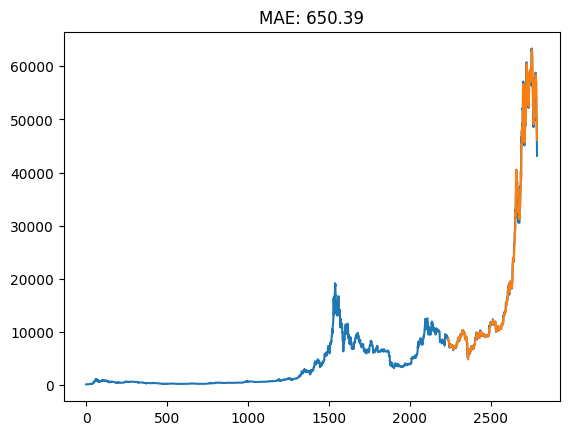

In [32]:
evaluate_model(y_test,model_5.predict(X_test,verbose=0))

### 6 RNN (BI LSTM)

In [33]:
X_win, y_win = window_data(y,1,7)

X_train = np.expand_dims(X_win[:train_size],axis=2)
X_test = np.expand_dims(X_win[train_size:],axis=2)
y_train = y_win[:train_size]
y_test = y_win[train_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2230, 7, 1), (550, 7, 1), (2230, 1), (550, 1))

In [34]:
model_6 = tf.keras.models.Sequential([
    layers.Input((7,1)),
    layers.Bidirectional(layers.LSTM(64,return_sequences=True,activation='relu')),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1,activation='linear')
])

model_6.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_6.summary()

# model_6.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
#             callbacks=[create_check_point('model_6')])
# model_6 = tf.keras.models.load_model('model_6')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 7, 128)            33792     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33921 (132.50 KB)
Trainable params: 33921 (132.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# evaluate_model(y_test,model_6.predict(X_test,verbose=0))

### 7 Multivariat (Feature Engineering, adding halving info to our data)

In [36]:
df['Reward'] = None

In [37]:
df.loc[df.index < '2012-11-28', 'Reward'] = 50
df.loc['2012-11-28':'2016-07-08', 'Reward'] = 25
df.loc['2016-07-09':'2020-05-10', 'Reward'] = 12.5
df.loc['2020-05-11':'2024-04-21', 'Reward'] = 6.25
df

,Price,Reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


In [38]:
data = df[['Price','Reward']].values

X_win,y_win = window_data(data,1,7)

X_train = X_win[:train_size]
X_test = X_win[train_size:]

y_train = y_win[:train_size]
y_test = y_win[train_size:]

In [39]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2230, 7, 2), (550, 7, 2), (2230, 1, 2), (550, 1, 2))

In [44]:
model_7 = tf.keras.models.Sequential([
    layers.Input((7,2)),
    layers.Conv1D(64,2,padding='same'),
    layers.GlobalMaxPool1D(),
    layers.Dense(1,activation='linear')
])

model_7.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_7.summary()

# model_7.fit(X_train,y_train, epochs=10,validation_data =(X_test,y_test),
#             callbacks=[create_check_point('model_7')])
# model_7 = tf.keras.models.load_model('model_7')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 64)             320       
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 8 N-BEATS

In [45]:
X_win, y_win = window_data(y,1,7)

train_size = 2224
X_train = X_win[:train_size]
X_test = X_win[train_size:]
y_train = y_win[:train_size]
y_test = y_win[train_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [46]:


class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons,activation='relu') for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size,activation='linear',name='theta')


  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast

In [47]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32*20).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32*20).prefetch(tf.data.AUTOTUNE)


In [48]:
N_EPOCHS = 5000
N_NEOURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [49]:
input = layers.Input((INPUT_SIZE))
x = NBeatsBlock(input_size = INPUT_SIZE,
                    theta_size = THETA_SIZE,
                    horizon= HORIZON,
                    n_neurons= N_NEOURONS,
                    n_layers= N_LAYERS)(input)

adding_layers = [x[1]]
subtract = layers.Subtract()([x[0],input])
for _ in range(N_STACKS-1):

  x = NBeatsBlock(input_size = INPUT_SIZE,
                    theta_size = THETA_SIZE,
                    horizon= HORIZON,
                    n_neurons= N_NEOURONS,
                    n_layers= N_LAYERS)(subtract)
  adding_layers.append(x[1])
  subtract = layers.Subtract()([x[0],subtract])


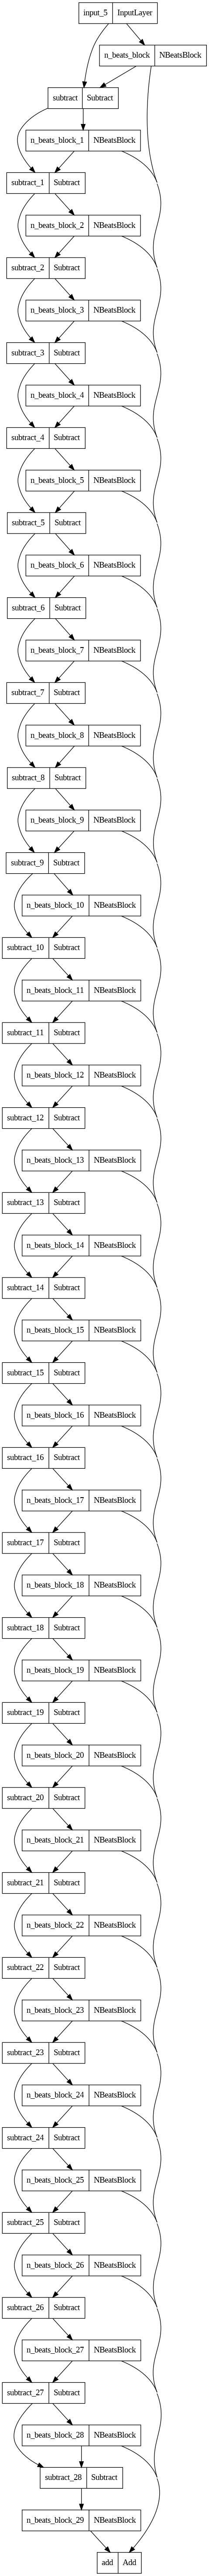

In [50]:
output = layers.Add()(adding_layers)
model_8 = tf.keras.models.Model(input,output)
tf.keras.utils.plot_model(model_8)

In [54]:
model_8.compile(loss='mae',optimizer='adam',metrics=['mae'])
model_8.fit(X_train,y_train,epochs = 10,validation_data=(X_test,y_test),callbacks=[create_check_point('model_8')])

Epoch 1/10
70/70 [==============================] - 79s 488ms/step - loss: 116.1330 - mae: 116.1330 - val_loss: 696.4808 - val_mae: 696.4808
Epoch 2/10
70/70 [==============================] - 26s 372ms/step - loss: 113.7509 - mae: 113.7509 - val_loss: 667.1371 - val_mae: 667.1371
Epoch 3/10
70/70 [==============================] - 25s 367ms/step - loss: 114.4824 - mae: 114.4824 - val_loss: 654.6392 - val_mae: 654.6392
Epoch 4/10
70/70 [==============================] - 25s 367ms/step - loss: 114.0641 - mae: 114.0641 - val_loss: 615.5541 - val_mae: 615.5541
Epoch 5/10
70/70 [==============================] - 26s 369ms/step - loss: 111.6731 - mae: 111.6731 - val_loss: 598.3856 - val_mae: 598.3856
Epoch 6/10
70/70 [==============================] - 27s 392ms/step - loss: 115.4500 - mae: 115.4500 - val_loss: 571.3988 - val_mae: 571.3988
Epoch 7/10
70/70 [==============================] - 4s 59ms/step - loss: 115.5893 - mae: 115.5893 - val_loss: 626.7359 - val_mae: 626.7359
Epoch 8/10
70/7

In [55]:
model_8 = tf.keras.models.load_model('model_8')

### 9 Ensemble of Models

In [81]:
def  get_ensemble_models(train_data = (X_train,y_train),
                         test_data=(X_test,y_test),
                         num_iter = 10,
                         loss_fncs=['mae','mse','mape']):
  ensemble_models = []
  for i in range(num_iter):
    for loss_function in loss_fncs:
      print(f'optimizing model by reducing {loss_function} model num {i}')
      model = tf.keras.models.Sequential([
          layers.Dense(64*2,kernel_initializer='he_normal',activation='relu'),
          layers.Dense(64*2,kernel_initializer='he_normal',activation='relu'),
          layers.Dense(1,activation='linear')
      ])
      model.compile(loss=loss_function, optimizer='adam',metrics=['mae'])
      model.fit(train_data[0],
                train_data[1],
                epochs=20,
                validation_data=test_data,
                verbose=0,
                callbacks=[tf.keras.callbacks.ModelCheckpoint('model',save_best_only=True)])
      model = tf.keras.models.load_model('model')

      ensemble_models.append(model)
  return ensemble_models

In [82]:
ensemble_models = get_ensemble_models(train_data = (X_train,y_train),
                         test_data=(X_test,y_test),
                         num_iter = 10,
                         loss_fncs=['mae','mse','mape'])

optimizing model by reducing mae model num 0
optimizing model by reducing mse model num 0
optimizing model by reducing mape model num 0
optimizing model by reducing mae model num 1
optimizing model by reducing mse model num 1
optimizing model by reducing mape model num 1
optimizing model by reducing mae model num 2
optimizing model by reducing mse model num 2
optimizing model by reducing mape model num 2
optimizing model by reducing mae model num 3
optimizing model by reducing mse model num 3
optimizing model by reducing mape model num 3
optimizing model by reducing mae model num 4
optimizing model by reducing mse model num 4
optimizing model by reducing mape model num 4
optimizing model by reducing mae model num 5
optimizing model by reducing mse model num 5
optimizing model by reducing mape model num 5
optimizing model by reducing mae model num 6
optimizing model by reducing mse model num 6
optimizing model by reducing mape model num 6
optimizing model by reducing mae model num 7
opt

In [83]:
predictions = []
for model in ensemble_models:
  predictions.append(model.predict(X_test))

18/18 [==============================] - 0s 2ms/step


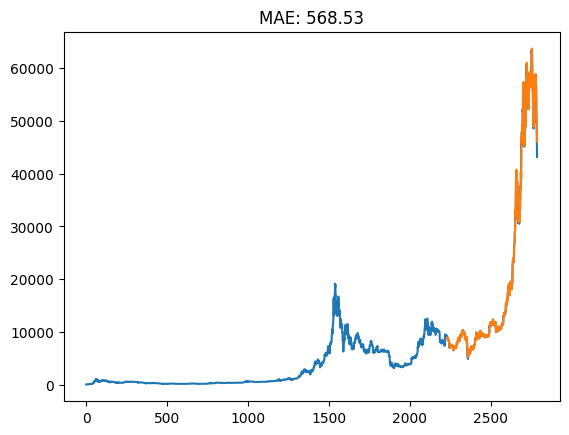

In [84]:
evaluate_model(y_test,
               tf.squeeze(np.array(tf.reduce_mean(predictions,axis=0))).numpy(),
               x=X[len(df)-len(y_test):])

In [93]:
mean = np.mean(np.array(predictions),axis=0)
std = np.std(np.array(predictions),axis=0)


upper_bound = mean + std*1.96
mean = mean
lower_bound = mean - std*1.96


X_fcst = X[len(df)-len(y_test):]

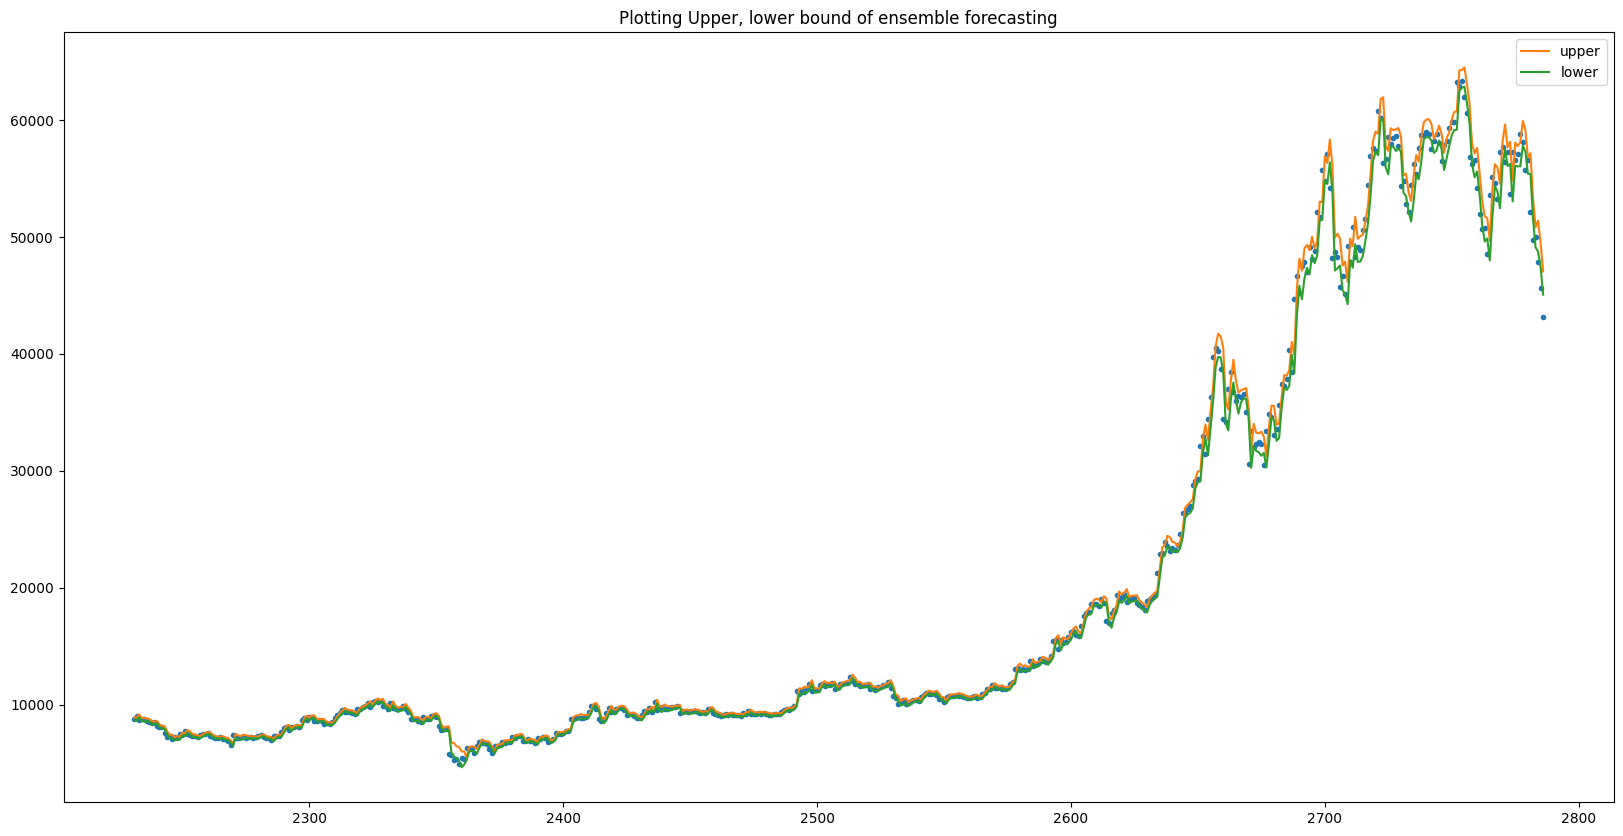

In [107]:
plt.figure(figsize=(20,10))
plt.plot(X[2231:],y[2231:],'.')
plt.plot(X_fcst,upper_bound,'-',label='upper')
# plt.plot(X_fcst,mean,'-',label='mean')
plt.plot(X_fcst,lower_bound,'-',label='lower')

plt.title('Plotting Upper, lower bound of ensemble forecasting')
plt.legend()
plt.show()

10 Predect the future

In [193]:
X_win.shape,y_win.shape

((2780, 7), (2780, 1))

In [114]:
model_10 = tf.keras.models.clone_model(model_5)
model_10.compile(optimizer = 'adam',loss='mae',metrics=['mae'])
model_10.fit(X_win,y_win,epochs=20)

Epoch 1/20
87/87 [==============================] - 2s 5ms/step - loss: 1055.8051 - mae: 1055.8051
Epoch 2/20
87/87 [==============================] - 1s 6ms/step - loss: 346.5328 - mae: 346.5328
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 324.2543 - mae: 324.2543
Epoch 4/20
87/87 [==============================] - 1s 6ms/step - loss: 321.3552 - mae: 321.3552
Epoch 5/20
87/87 [==============================] - 1s 7ms/step - loss: 295.4000 - mae: 295.4000
Epoch 6/20
87/87 [==============================] - 0s 4ms/step - loss: 262.7535 - mae: 262.7535
Epoch 7/20
87/87 [==============================] - 0s 5ms/step - loss: 248.6238 - mae: 248.6238
Epoch 8/20
87/87 [==============================] - 0s 5ms/step - loss: 277.6562 - mae: 277.6562
Epoch 9/20
87/87 [==============================] - 0s 5ms/step - loss: 232.8503 - mae: 232.8503
Epoch 10/20
87/87 [==============================] - 0s 4ms/step - loss: 249.0265 - mae: 249.0265
Epoch 11/20
87/87 [========

In [122]:
y_win[-1]

array([43144.47129086])

In [128]:
X_win[-1]

array([55715.54665129, 56573.5554719 , 52147.82118698, 49764.1320816 ,
       50032.69313676, 47885.62525472, 45604.61575361])

In [190]:
window = np.expand_dims(np.concatenate([X_win[-1:][0][1:],y_win[-1]]),axis=0)
window
predictions = []

In [191]:
for i in range(100):
  pred_step = model_10.predict(window,verbose=0)
  predictions.extend(pred_step[0])
  window = np.expand_dims(np.concatenate([window[0][1:],pred_step[0]]),axis=0)

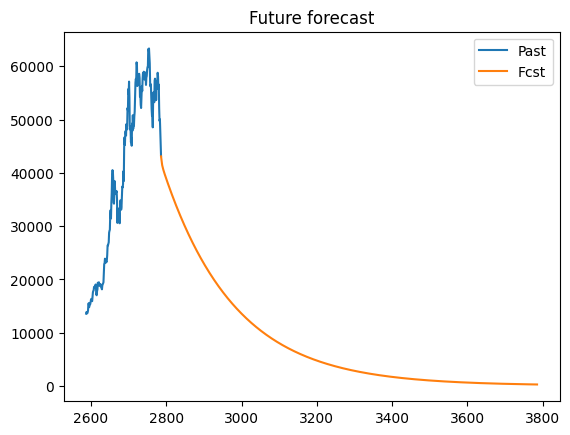

In [270]:
plt.plot(X[-200:],y[-200:],label='Past')
plt.plot(range(X[-1],X[-1]+len(predictions)),
         predictions,label='Fcst')
plt.title('Future forecast')
plt.legend()
plt.show()

In [252]:
# Retrain after each prediction
model_10 = tf.keras.models.clone_model(model_5)
model_10.compile(optimizer = 'adam',loss='mae',metrics=['mae'])
model_10.fit(X_win,y_win,epochs=20)

Epoch 1/20
87/87 [==============================] - 1s 3ms/step - loss: 772.2297 - mae: 772.2297
Epoch 2/20
87/87 [==============================] - 0s 3ms/step - loss: 431.1706 - mae: 431.1706
Epoch 3/20
87/87 [==============================] - 0s 3ms/step - loss: 377.3151 - mae: 377.3151
Epoch 4/20
87/87 [==============================] - 0s 3ms/step - loss: 343.3370 - mae: 343.3370
Epoch 5/20
87/87 [==============================] - 0s 3ms/step - loss: 321.1790 - mae: 321.1790
Epoch 6/20
87/87 [==============================] - 0s 3ms/step - loss: 283.6515 - mae: 283.6515
Epoch 7/20
87/87 [==============================] - 0s 3ms/step - loss: 280.2924 - mae: 280.2924
Epoch 8/20
87/87 [==============================] - 0s 3ms/step - loss: 269.2199 - mae: 269.2199
Epoch 9/20
87/87 [==============================] - 0s 3ms/step - loss: 253.4088 - mae: 253.4088
Epoch 10/20
87/87 [==============================] - 0s 3ms/step - loss: 234.1259 - mae: 234.1259
Epoch 11/20
87/87 [==========

In [265]:
X_win,y_win = window_data(y,1,7)

In [266]:
prediction = []


for _ in range(50):
  X_step = np.concatenate([X_win[-1][1:],y_win[-1]])
  y_step = model_10.predict(np.expand_dims(X_step,axis=0),verbose=0)[0]

  prediction.extend(y_step)
  y_win = np.concatenate([y_win,np.expand_dims(y_step,axis=0)])
  X_win = np.concatenate([X_win,np.expand_dims(X_step,axis=0)])

  model_10.compile(optimizer = 'adam',loss='mae',metrics=['mae'])
  model_10.fit(X_win,y_win,epochs=20,verbose=0)



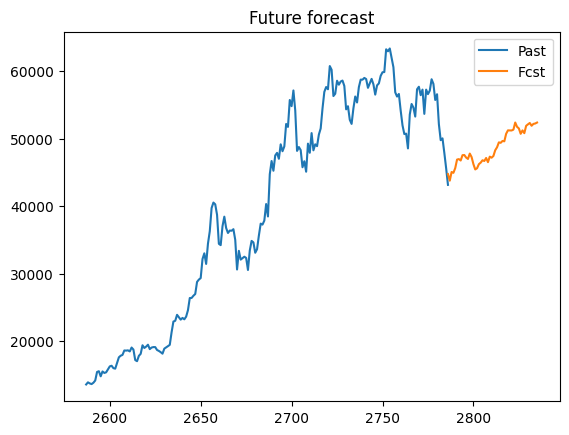

In [269]:
plt.plot(X[-200:],y[-200:],label='Past')
plt.plot(range(X[-1],X[-1]+len(prediction)),
         prediction,label='Fcst')
plt.title('Future forecast')
plt.legend()
plt.show()